# Проект "В один клик"

**Описание проекта:** компания "В один клик" в рамках своей операционной деятельности столкнулся с ситуацией снижения активности покупателей. Необходимо удержать целевую аудиторию при помощи персонализированных предложений.

**Цель исследования:** разработка решения для выработки персонализированных предложений постоянным клиентам с целью увеличения покупательской активности.

In [10]:
# скачиваем требуемые библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# скачиваем требуемые библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Загрузка данных:

In [12]:
market_file_data = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_file_data.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [13]:
market_money_data = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_money_data.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [14]:
market_time_data = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
market_time_data.head(5)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [15]:
money_data = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')
money_data.head(5)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Вывод**

Данные, представленные Заказчиком, успешно загружены и соответствуют описанию. 

## Предобработка данных

### Датасет: "market_file_data"

In [16]:
market_file_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [17]:
# переименуем названия столбцов в snake_format
new_col = ['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит']
market_file_data.columns = new_col

In [18]:
market_file_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

**Анализ категориальных данных**

In [19]:
cat_col = market_file_data.select_dtypes(['object']).columns
market_file_data[cat_col].describe()

,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
count,1300,1300,1300,1300
unique,2,3,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,914,962,330


In [20]:
# проанализируем значения категориальных данных
for col in cat_col:
    print(f"Столбец: {col}\n {market_file_data[col].unique().tolist()}")

Столбец: покупательская_активность
 ['Снизилась', 'Прежний уровень']
Столбец: тип_сервиса
 ['премиум', 'стандартт', 'стандарт']
Столбец: разрешить_сообщать
 ['да', 'нет']
Столбец: популярная_категория
 ['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары', 'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника']


Выявлены ошибки в названии категориальных данных, также необходимо перевести названия в "snake_format".

In [21]:
# "покупательская_активность"
col_map = {
    'Снизилась': 'cнизилась',
    'Прежний уровень': 'прежний_уровень'
}
market_file_data['покупательская_активность'] = market_file_data['покупательская_активность'].map(col_map)

# "тип_сервиса"
col_map = {
    'стандартт': 'стандарт',
    'премиум': 'премиум',
    'стандарт' : 'стандарт'
}
market_file_data['тип_сервиса'] = market_file_data['тип_сервиса'].map(col_map)

# "популярная_категория"
col_map = {
    'Товары для детей': 'товары_для_детей',
    'Домашний текстиль': 'домашний_текстиль',
    'Косметика и аксесуары': 'косметика_и_аксесуары',
    'Техника для красоты и здоровья': 'техника_для_красоты_и_здоровья',
    'Кухонная посуда': 'кухонная_посуда',
    'Мелкая бытовая техника и электроника': 'мелкая_бытовая_техника_и_электроника',
}
market_file_data['популярная_категория'] = market_file_data['популярная_категория'].map(col_map)

**Анализ количественных данных**

In [22]:
num_col = market_file_data.select_dtypes(['int', 'float']).columns
market_file_data[num_col].describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [23]:
# анализ явных дубликатов
market_file_data.duplicated().sum()

0

**Вывод**

Данные не содержат пропущенных значений. Названия столбцов скорректированы в "snake_format". Датасет включает 13 столбцов из которых 4 категориальные, 9 количественные. Значения категориальных признаков скорректированы: исправлены ошибки в значениях, скорректирован формат.

### Датасет: "market_money_data"

In [24]:
market_money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [25]:
market_money_data.columns = ['id', 'период', 'выручка']

**Анализ категориальных данных**

In [26]:
cat_col = market_money_data.select_dtypes(['object']).columns
market_money_data[cat_col].describe()

,период
count,3900
unique,3
top,препредыдущий_месяц
freq,1300


In [27]:
# проанализируем значения категориальных данных
for col in cat_col:
    print(f"Столбец: {col}\n {market_money_data[col].unique().tolist()}")

Столбец: период
 ['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц']


**Анализ количественных данных**

In [28]:
num_col = market_money_data.select_dtypes(['int', 'float']).columns
market_money_data[num_col].describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [29]:
# анализ явных дубликатов
market_money_data.duplicated().sum()

0

**Вывод**

Данные не содержат пропущенных значений. Явные дубликаты отсутствуют. Названия столбцов скорректированы в "snake_format". Датасет включает 2 столбца из которых 1 категориальный, 2 количественных.

### Датасет: "market_time_data"

In [30]:
market_time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [31]:
market_time_data.columns =['id', 'период', 'минут']

**Анализ категориальных данных**

In [32]:
cat_col = market_time_data.select_dtypes(['object']).columns
market_time_data[cat_col].describe()

,период
count,2600
unique,2
top,текущий_месяц
freq,1300


In [33]:
# проанализируем значения категориальных данных
for col in cat_col:
    print(f"Столбец: {col}\n {market_time_data[col].unique().tolist()}")

Столбец: период
 ['текущий_месяц', 'предыдцщий_месяц']


Выявлены ошибки в названии категориальных данных.

In [34]:
# "период"
col_map = {
    'текущий_месяц': 'текущий_месяц',
    'предыдцщий_месяц': 'предыдущий_месяц'
}
market_time_data['период'] = market_time_data['период'].map(col_map)

**Анализ количественных данных**

In [35]:
num_col = market_time_data.select_dtypes(['int', 'float']).columns
market_time_data[num_col].describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [36]:
# анализ явных дубликатов
market_time_data.duplicated().sum()

0

**Вывод**

Данные не содержат пропущенных значений. Явные дубликаты отсутствуют. Названия столбцов скорректированы в "snake_format". Датасет включает 2 столбца из которых 1 категориальный, 2 количественных. Выявлены и исправлены ошибки в значениях категориальных данных.

### Датасет: "money_data"

In [37]:
money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [38]:
money_data.columns = ['id', 'прибыль']

**Анализ количественных данных**

In [39]:
num_col = money_data.select_dtypes(['int', 'float']).columns
money_data[num_col].describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


In [40]:
money_data.duplicated().sum()

0

**Вывод**

Данные не содержат пропущенных значений. Явные дубликаты отсутствуют. Названия столбцов скорректированы в "snake_format". Датасет включает 2 количественных столбца.

### Общий вывод

Выполнена предобработка данных в 4 предоставленных датасетах. Во всех датасетах названия столбцов отформатированы в "snake_format". В значениях категориальных данных выявлены и исправлены ошибки. Явные дубликаты и пропущенные значения отсутствуют.

## Объединение данных

Все предоставленные датасеты имеют общий столбец - "id". По нему будет выполнено объединение данных для последующего исследовательного анализа. В рамках предобработки данных можно было заметить, что датасеты "market_money_data" и "market_time_data" имеют "длинный формат". Для корректного обьединения данных необходимо переформатировать датасеты в "широкий формат".

In [41]:
# переформатируем датасет market_money_data в широкий формат
market_money_data_wide = market_money_data.pivot(index='id', columns='период', values='выручка')
market_money_data_wide = market_money_data_wide.reset_index()
market_money_data_wide.columns = ['id', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_data_wide.head(5)

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5


In [42]:
# переформатируем датасет market_time_data в широкий формат
market_time_data_wide = market_time_data.pivot(index='id', columns='период', values='минут')
market_time_data_wide = market_time_data_wide.reset_index()
market_time_data_wide.columns = ['id', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_data_wide.head(5)

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [43]:
# выполним объединение датасетов и выведем результат
print(f"Размерность датасета market_file_data: {market_file_data.shape}")
print(f"Размерность датасета market_money_data_wide: {market_money_data_wide.shape}")
print(f"Размерность датасета market_time_data_wide: {market_time_data_wide.shape}")

total_data = pd.merge(market_file_data, market_money_data_wide, on='id', how='outer')
total_data = pd.merge(total_data, market_time_data_wide, on='id', how='outer')
total_data = pd.merge(total_data, money_data, on='id', how='outer')
total_data = total_data.set_index('id')
print(f"Размерность датасета после объединения: {total_data.shape}")
total_data.head(5)

Размерность датасета market_file_data: (1300, 13)
Размерность датасета market_money_data_wide: (1300, 4)
Размерность датасета market_time_data_wide: (1300, 3)
Размерность датасета после объединения: (1300, 18)


,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прибыль
id,,,,,,,,,,,,,,,,,,
215348,cнизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,0.0,0.0,3293.1,13,14,0.98
215349,cнизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
215350,cнизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
215351,cнизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
215352,cнизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21


In [44]:
# исключим наблюдения с нулевой выручкой хотя бы и одном пероиде
total_data = total_data [
    (total_data['выручка_предыдущий_месяц'] != 0) &
    (total_data['выручка_препредыдущий_месяц'] != 0) &
    (total_data['выручка_текущий_месяц'] != 0)
]

In [45]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1297 non-null   object 
 1   тип_сервиса                          1297 non-null   object 
 2   разрешить_сообщать                   1297 non-null   object 
 3   маркет_актив_6_мес                   1297 non-null   float64
 4   маркет_актив_тек_мес                 1297 non-null   int64  
 5   длительность                         1297 non-null   int64  
 6   акционные_покупки                    1297 non-null   float64
 7   популярная_категория                 1297 non-null   object 
 8   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  ошибка_сервиса                       1297 non-null   int64  
 11  страниц_за_визит            

### Общий вывод

Данные успешно объединены. Итоговый датасет имеет размерность 1300 строк и 18 колонок. Пропущенные значения отсутствуют.

## Исследовательский анализ данных

In [46]:
# выделим количественные и категориальные данные
num_col = total_data.select_dtypes(['int', 'float']).columns
cat_col = total_data.select_dtypes(['object']).columns

In [47]:
# функция для анализа категорийного ряда данных:
def complex_plot_cat(data, xlabel_def):
    data = data[xlabel_def].value_counts()
    x_val = data.index
    y_val = data.values
    y_val_perc = y_val / y_val.sum() * 100 
    #рисуем график:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x=x_val, height=y_val)
    #подписки баров:
    for i in range(len(y_val)):
        plt.text(i, y_val[i], f"{y_val[i]} ({y_val_perc[i].round(1)}%)", ha='center', va='bottom', fontsize=10, weight='bold')
    #рисуем и подписываем среднее значение:
    plt.axhline(data.mean(), color='red', linestyle='--', label=f'Средняя = {data.mean().round(2):,}')
    #настройка графика:
    ax.set_title('Диаграмма распределения')
    ax.set_xlabel(xlabel_def)
    ax.set_ylabel('Количество')
    ax.legend(bbox_to_anchor=(0.0, 0.2), loc='upper left')
    plt.show()

In [48]:
# функция для анализа количественного непрерывного ряда данных:
def complex_plot_num1(data, xlabel_def):
    data = data[xlabel_def]
    #рисуем графики:
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [7, 1]})
    #гистограмма:
    ax[0].hist(data, density=False)
    ax[0].set_title('Гистограмма распределения')
    ax[0].set_xlabel(xlabel_def)
    ax[0].set_ylabel('Количество')
    ax[0].axvline(x=data.mean(), color='red', linestyle='--', label=f'Средняя = {data.mean().round(2):,}')
    ax[0].legend(bbox_to_anchor=(0.0, 1.0), loc='upper left')
    #boxplot:
    ax[1].boxplot(data, vert=False, widths = 0.6)
    ax[1].set_axis_off()
    #таблица сводной статистики:
    plt.figtext(0.95,0.47, data.describe().round(2).to_string(), fontsize=15)
    plt.show()

In [49]:
# функция для анализа количественного дискретного ряда данных:
def complex_plot_num2(data, xlabel_def):
    x_col = xlabel_def
    count = total_data[x_col].value_counts().sort_index()
    x_val = count.index
    y_val = count.values
    y_val_perc = y_val / y_val.sum() * 100
    # отрисовка графика
    fig, ax = plt.subplots(figsize=(12, 5))
    ax = sns.countplot(x=x_col, data=total_data)
    ax.set_title('Гистограмма распределения')
    ax.set_xlabel(x_col)
    ax.set_ylabel('Количество')
    #подписки баров:
    for i in range(len(y_val)):
        plt.text(i, y_val[i], f"{y_val[i]} ({y_val_perc[i].round(1)}%)", ha='center', va='bottom', fontsize=10, weight='bold')
    plt.show()

### Количественные данные

#### признак: "маркет_актив\_6_мес"

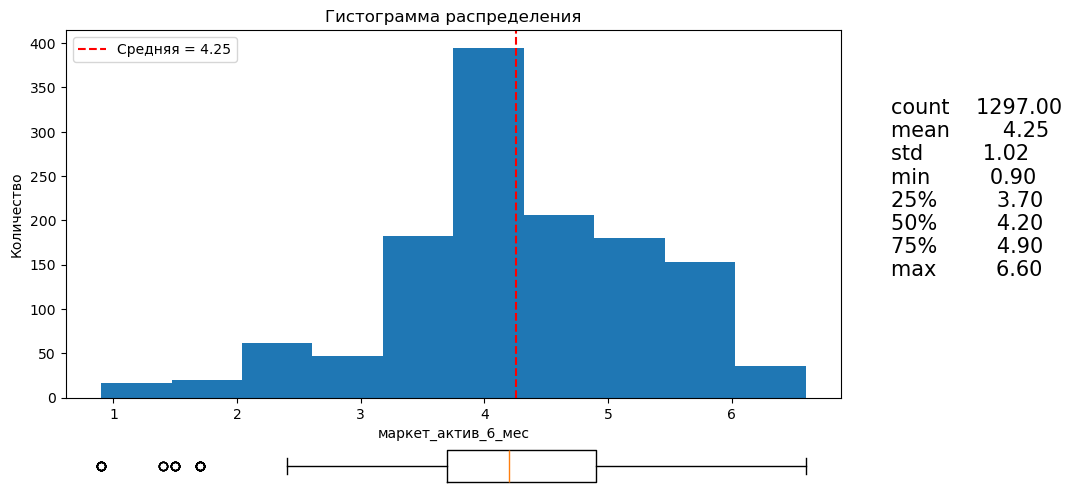

In [50]:
complex_plot_num1(total_data, xlabel_def='маркет_актив_6_мес')

Распределение "маркет_актив\_6_мес" нельзя однозначно классифицировать. Среднее значение 4.25. Имеется несколько выбросов в области низких значений.

#### признак: "маркет_актив_тек_мес"

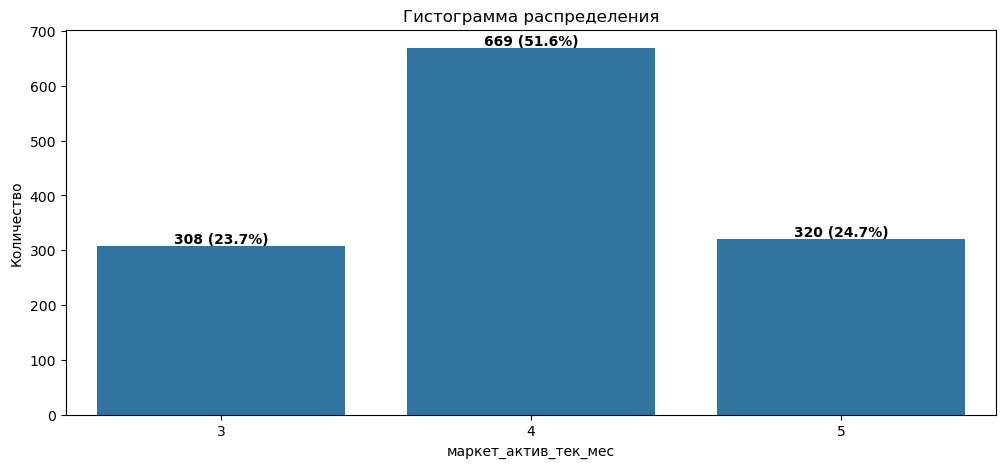

In [51]:
complex_plot_num2(total_data, xlabel_def='маркет_актив_тек_мес')

Данные "маркет_актив_тек_мес" представляет собой дискретный ряд из чисел 3, 4, 5 что заметно по графику выше. Заметно, что половина пользователей в среднем имели 4 комуникации.

#### признак: "длительность"

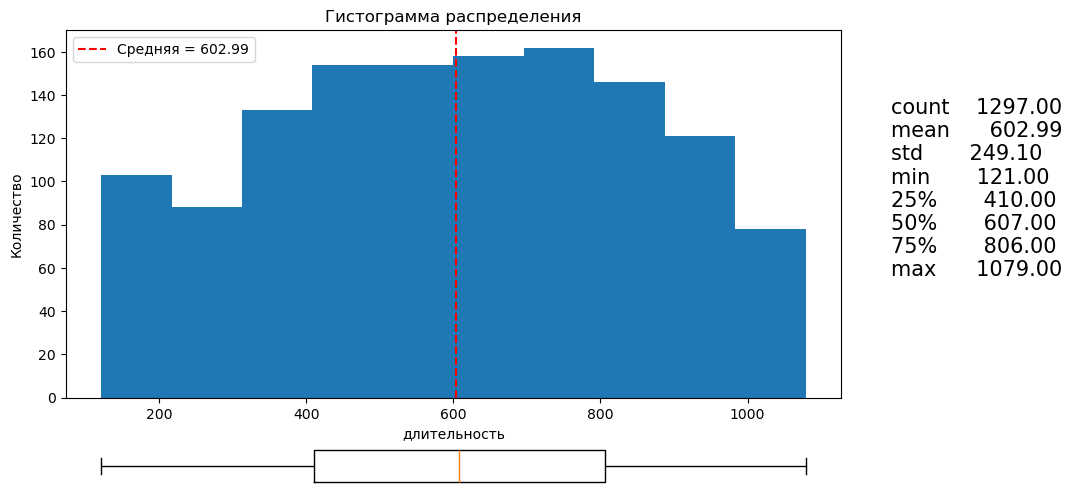

In [52]:
complex_plot_num1(total_data, xlabel_def='длительность')

Распределение "длительность" нельзя однозначно классифицировать. Среднее значение 601.9. Данные довольно однородные и симметричны относительно своего среднего.

#### признак: "акционные_покупки"

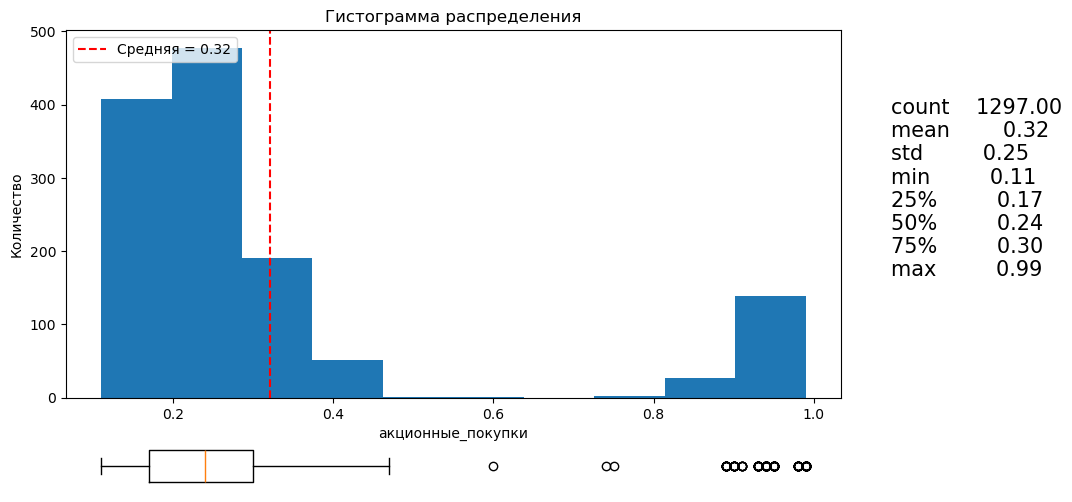

In [53]:
complex_plot_num1(total_data, xlabel_def='акционные_покупки')

Распределение "акционные_покупки" нельзя однозначно классифицировать. Среднее значение 0.32. Стоит отметить два "пика", при этом правый пик представлен гораздо меньшим количеством наблюдений (эти данные являются выбросами на графике "ящик с усами").

#### признак: "средний_просмотр_категорий_за_визит"

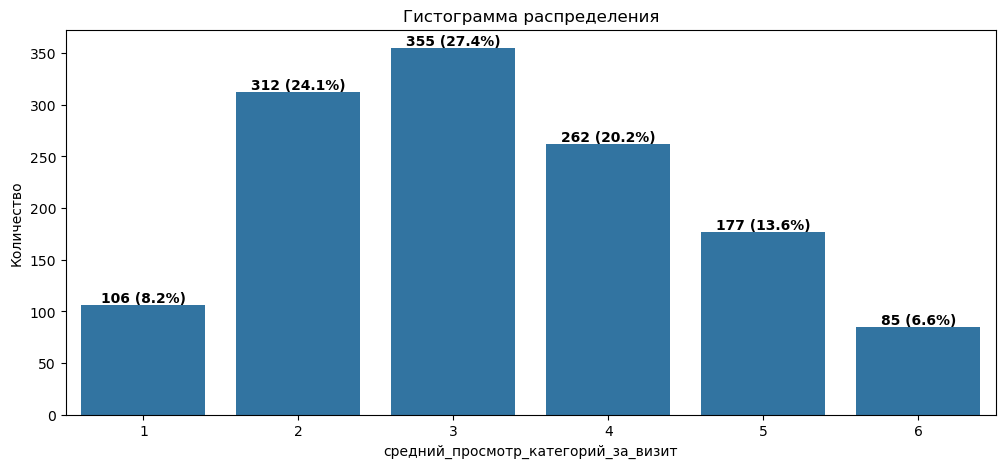

In [54]:
complex_plot_num2(total_data, xlabel_def='средний_просмотр_категорий_за_визит')

Данные "средний_просмотр_категорий_за_визит" представляет собой дискретный ряд натуральных чисел от 1 до 6.

#### признак: "неоплаченные_продукты_штук_квартал"

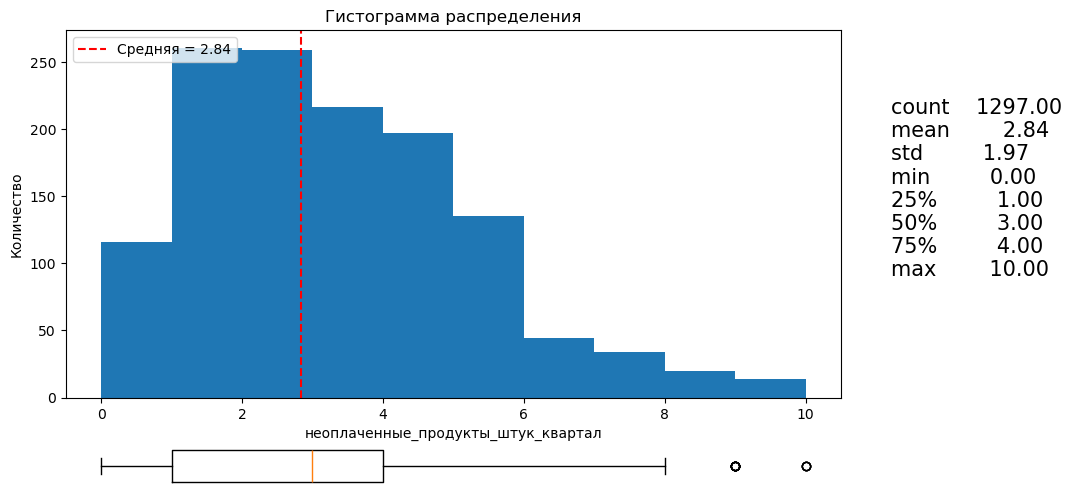

In [55]:
complex_plot_num1(total_data, xlabel_def='неоплаченные_продукты_штук_квартал')

Распределение "неоплаченные_продукты_штук_квартал" нельзя однозначно классифицировать, однако стоит отметить правосторонюю скошенность ряда. Среднее значение 2.84. Выявлено несколько выбросов высоких значений, которые не выглядят аномальными.

#### признак: "ошибка_сервиса"

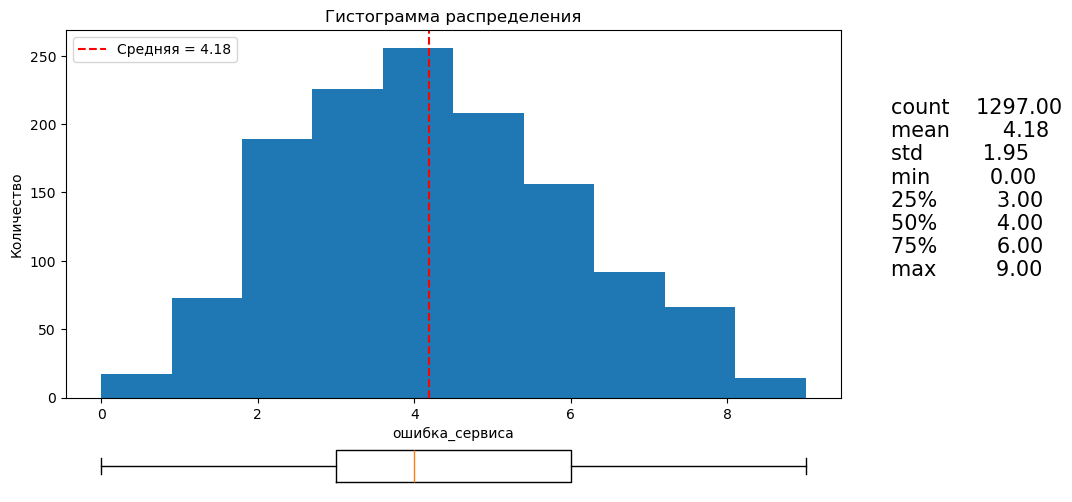

In [56]:
complex_plot_num1(total_data, xlabel_def='ошибка_сервиса')

Распределение "ошибка_сервиса" похоже на нормальное. Среднее значение 4.19.

#### признак: "страниц_за_визит"

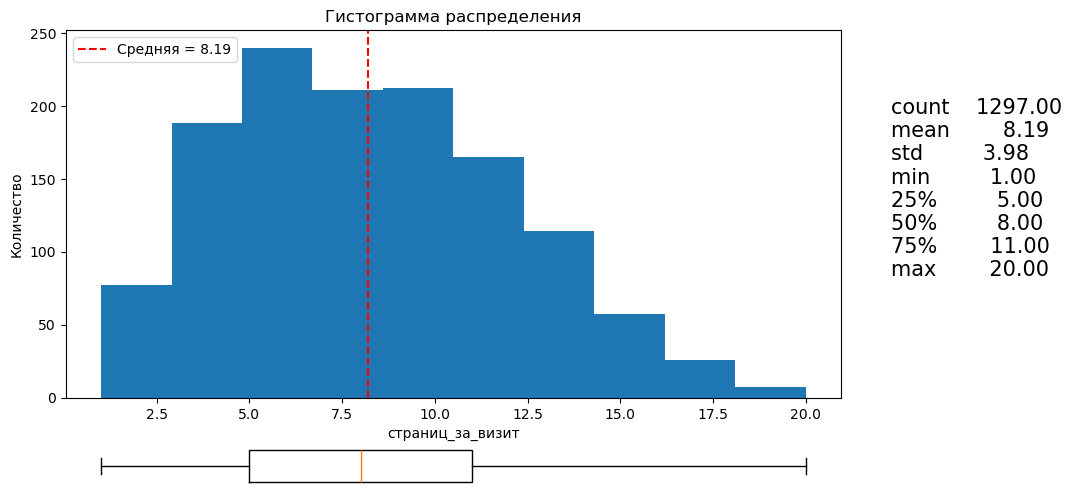

In [57]:
complex_plot_num1(total_data, xlabel_def='страниц_за_визит')

Распределение "страниц_за_визит" похоже на нормальное с правой скошенностью. Среднее значение 8.18.

#### признак: "выручка_предыдущий_месяц"

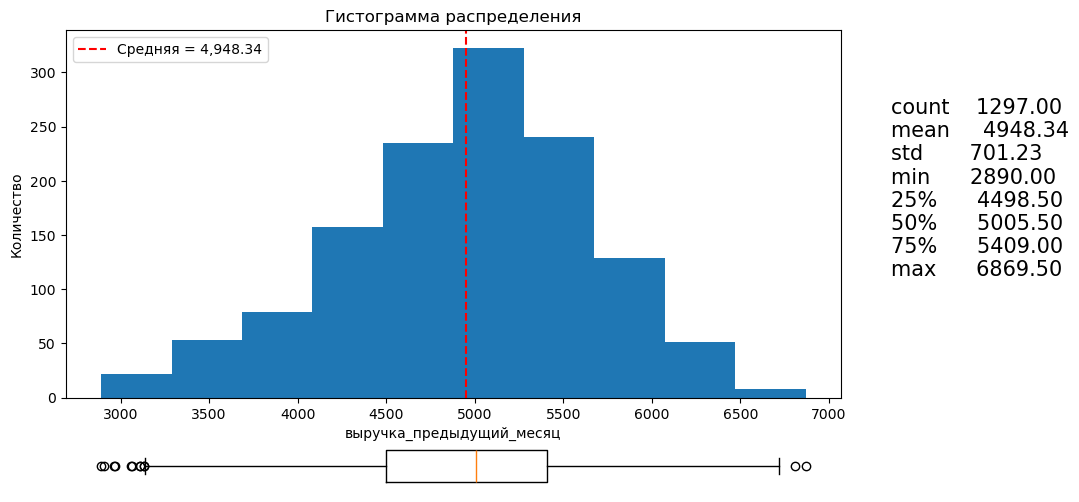

In [58]:
complex_plot_num1(total_data, xlabel_def='выручка_предыдущий_месяц')

Распределение "выручка_предыдущий_месяц" в диапазоне 2800-7000 похоже на нормальное. Анализ "ящика с усами" позволяет заметить наличие выбросов.

#### признак: "выручка_препредыдущий_месяц"

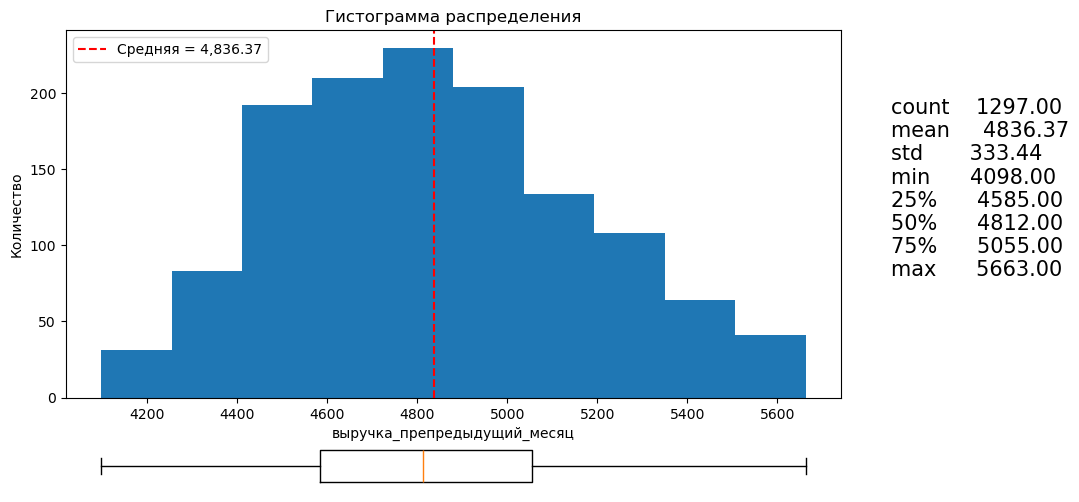

In [59]:
complex_plot_num1(total_data, xlabel_def='выручка_препредыдущий_месяц')

Распределение "выручка_препредыдущий_месяц" в диапазоне похоже на нормальное.

#### признак: "выручка_текущий_месяц"

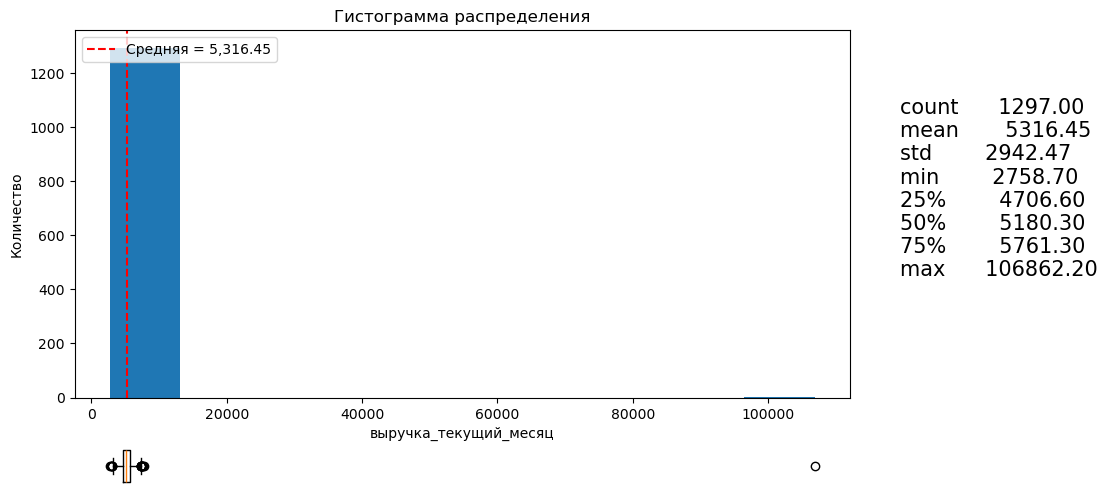

In [60]:
complex_plot_num1(total_data, xlabel_def='выручка_текущий_месяц')

Данные содержат анормально высокое значение, которое значительно превышает среднее.

In [61]:
# найдем значение которое выбивается из общей картины
total_data[total_data['выручка_текущий_месяц'] > 20000]

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прибыль
id,,,,,,,,,,,,,,,,,,
215380,cнизилась,премиум,нет,1.7,4,637,0.94,техника_для_красоты_и_здоровья,3,2,4,7,6077.0,5051.0,106862.2,12,14,3.88


In [62]:
# исключим данное наблюдение из выборки
total_data = total_data[total_data['выручка_текущий_месяц'] < 20000]

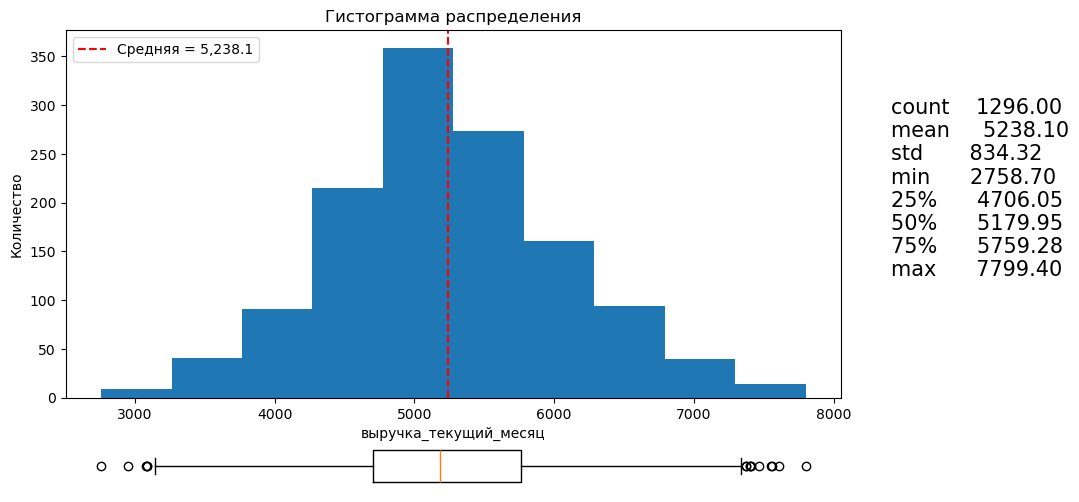

In [63]:
# график без аномального значения
complex_plot_num1(total_data, xlabel_def='выручка_текущий_месяц')

Распределение "выручка_текущий_месяц" похоже на нормальное. Среднее значение 5238.1.

#### признак: "минут_предыдущий_месяц"

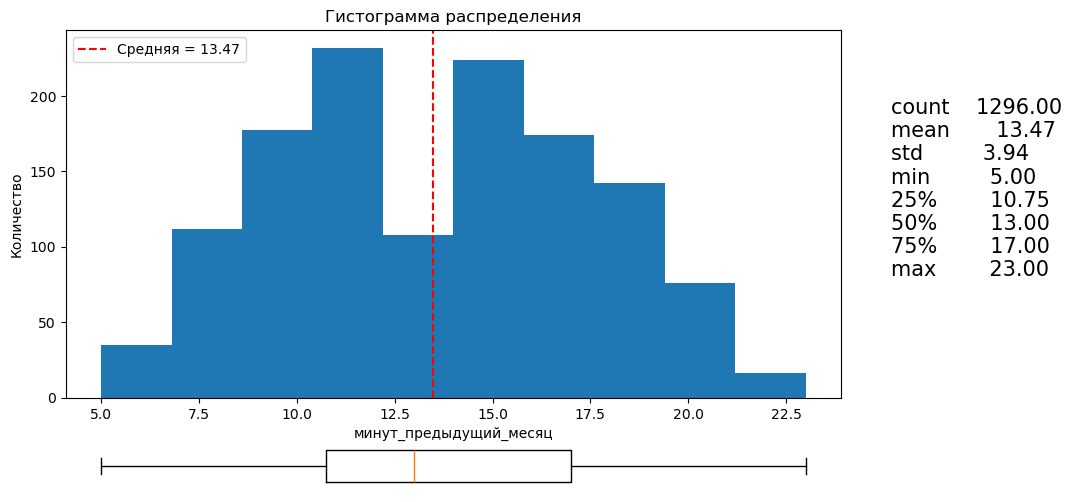

In [64]:
complex_plot_num1(total_data, xlabel_def='минут_предыдущий_месяц')

Распределение "минут_предыдущий_месяц" нельзя однозначно классифицировать, однако стоит отметить два пика, что говорит о том, что данные содержат два типичных близких значения. В целом ряд достаточно однородный и не содержит выбросов.Среднее значение 13.47.

#### признак: "минут_текущий_месяц"

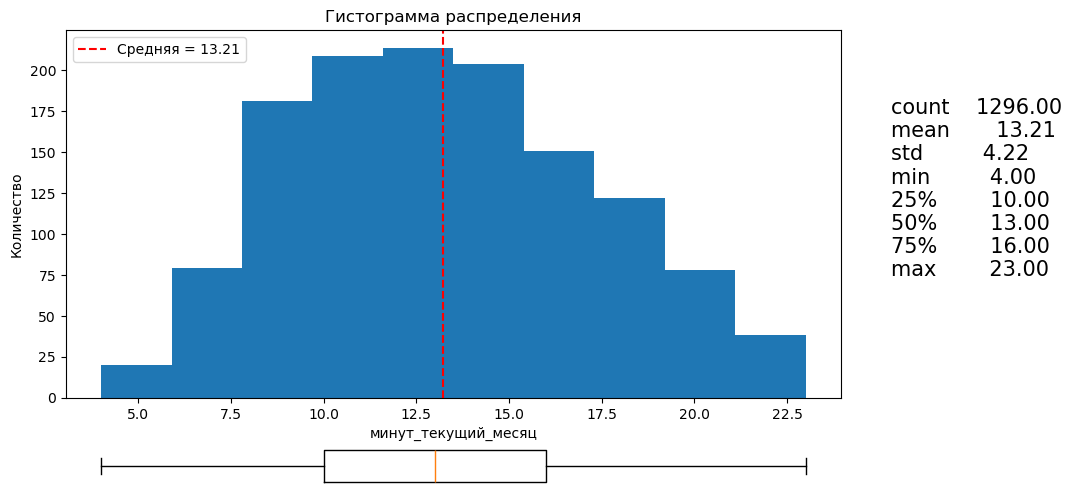

In [65]:
complex_plot_num1(total_data, xlabel_def='минут_текущий_месяц')

Распределение "минут_текущий_месяц" похоже на нормальное. Среднее значение 13.2.

### Категориальные данные

#### признак: "покупательская_активность"

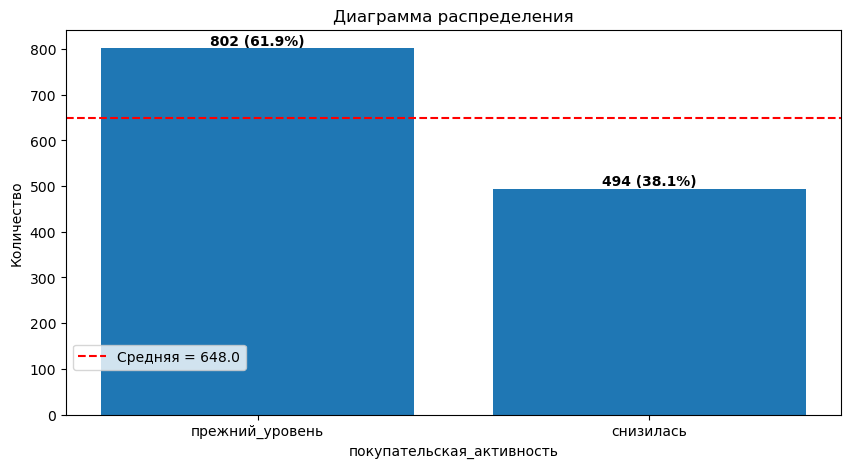

In [66]:
complex_plot_cat(data=total_data, xlabel_def='покупательская_активность')

Признак "покупательская_активность" является таргетом в рамках исследования. Для удобства работы с ним в дальнейшем расширим датасет закодировав таргет бинарным значением.

In [67]:
encoder = OrdinalEncoder(categories=[['прежний_уровень', 'cнизилась']])
total_data['покупательская_активность_бинар'] = encoder.fit_transform(total_data['покупательская_активность'].to_frame())

In [68]:
# переопределяем тип признаков
num_col = total_data.select_dtypes(['int', 'float']).columns
cat_col = total_data.select_dtypes(['object']).columns

Данные "покупательская_активность" представлены двумя значениями. Большинство значений - "прежний уровень" (61.9%).

#### признак: "тип_сервиса"

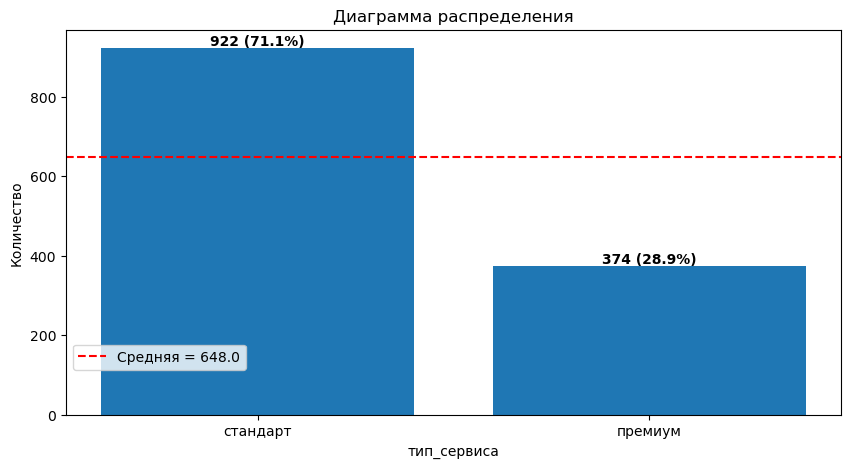

In [69]:
complex_plot_cat(data=total_data, xlabel_def='тип_сервиса')

Большинство покупателей имеют "тип_сервиса" = "стандарт" (71.1%).

#### признак: "разрешить_сообщать"

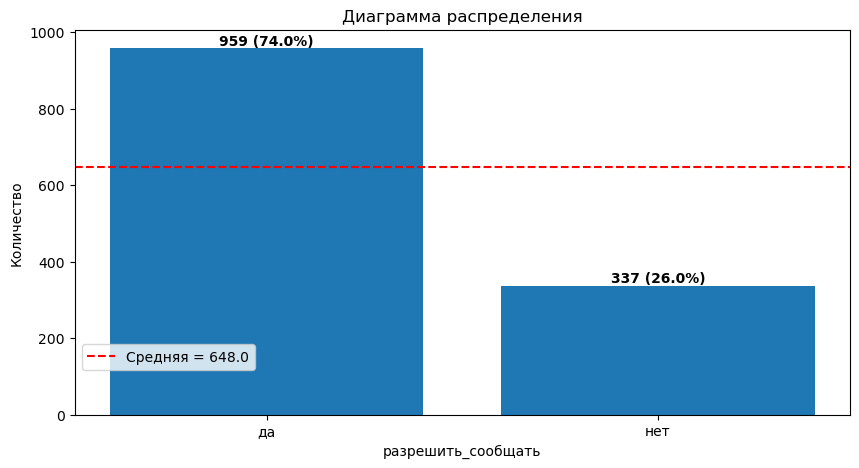

In [70]:
complex_plot_cat(data=total_data, xlabel_def='разрешить_сообщать')

Значительное число покупателей разрешают сообщения (74%).

#### признак: "популярная_категория"

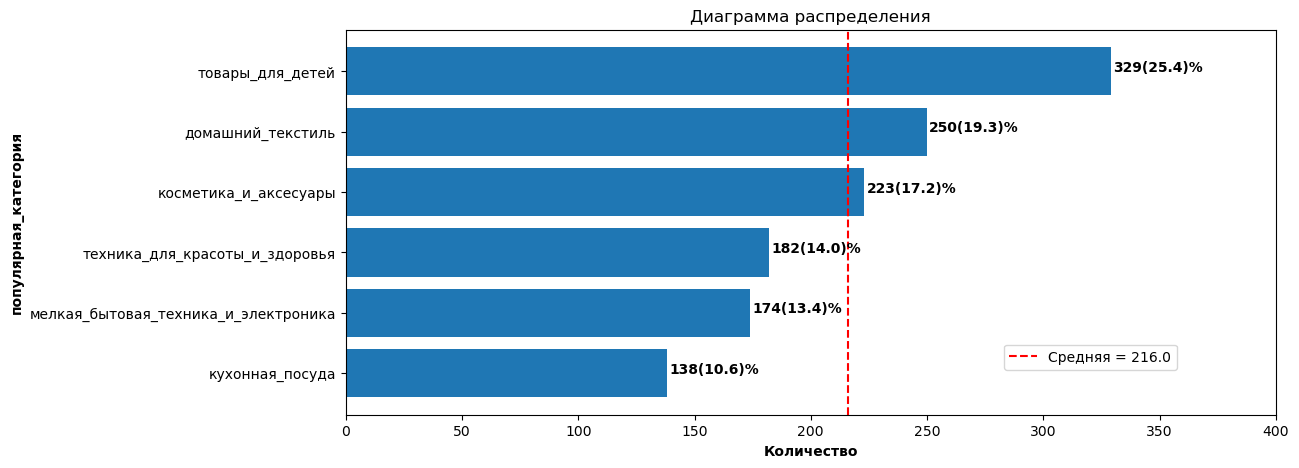

In [71]:
# данные для графика
plotdata = total_data['популярная_категория'].value_counts().sort_values()
x_val = plotdata.values
y_val = plotdata.index
x_val_perc = x_val / x_val.sum() * 100 
#рисуем график
fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(y=y_val, width=x_val)
#подписки баров
for i, x_i in enumerate(x_val):
    plt.text(x_i + 1, i, f"{x_i}({x_val_perc[i].round(1)})%", color='black', fontweight='bold')
#рисуем и подписываем среднее значение
plt.axvline(plotdata.mean(), color='red', linestyle='--', label=f'Средняя = {plotdata.mean().round(2):,}')
#настройка графика
ax.set_title('Диаграмма распределения')
ax.set_xlabel('Количество', fontweight='bold')
ax.set_xlim(0, 400)
ax.set_ylabel('популярная_категория', fontweight='bold')
ax.legend(bbox_to_anchor=(0.7, 0.2), loc='upper left')
plt.show()

Категории товаров представлены 6 видами. Самая популярные категории - "товары для детей" и "домашний текстиль".

### Общий вывод

В рамках исследовательского анализа данных были проанализированы все представленные данные. Исключено одно наблюдение которое было признано аномалией по показателю "выручка_текущего_месяца". Стоит отметить, что большинство покупателей (61.7%) сохраняют свою активность на прежнем уровне. Значительная часть покупателей используют тип сервиса "стандарт" (71.1%). 74% покупателей разрешают отправку сообщение и предложений. Наиболее популярные категории товаров это "товары для детей" и "домашний текстиль". 

## Корреляционный анализ

### Корреляционная матрица

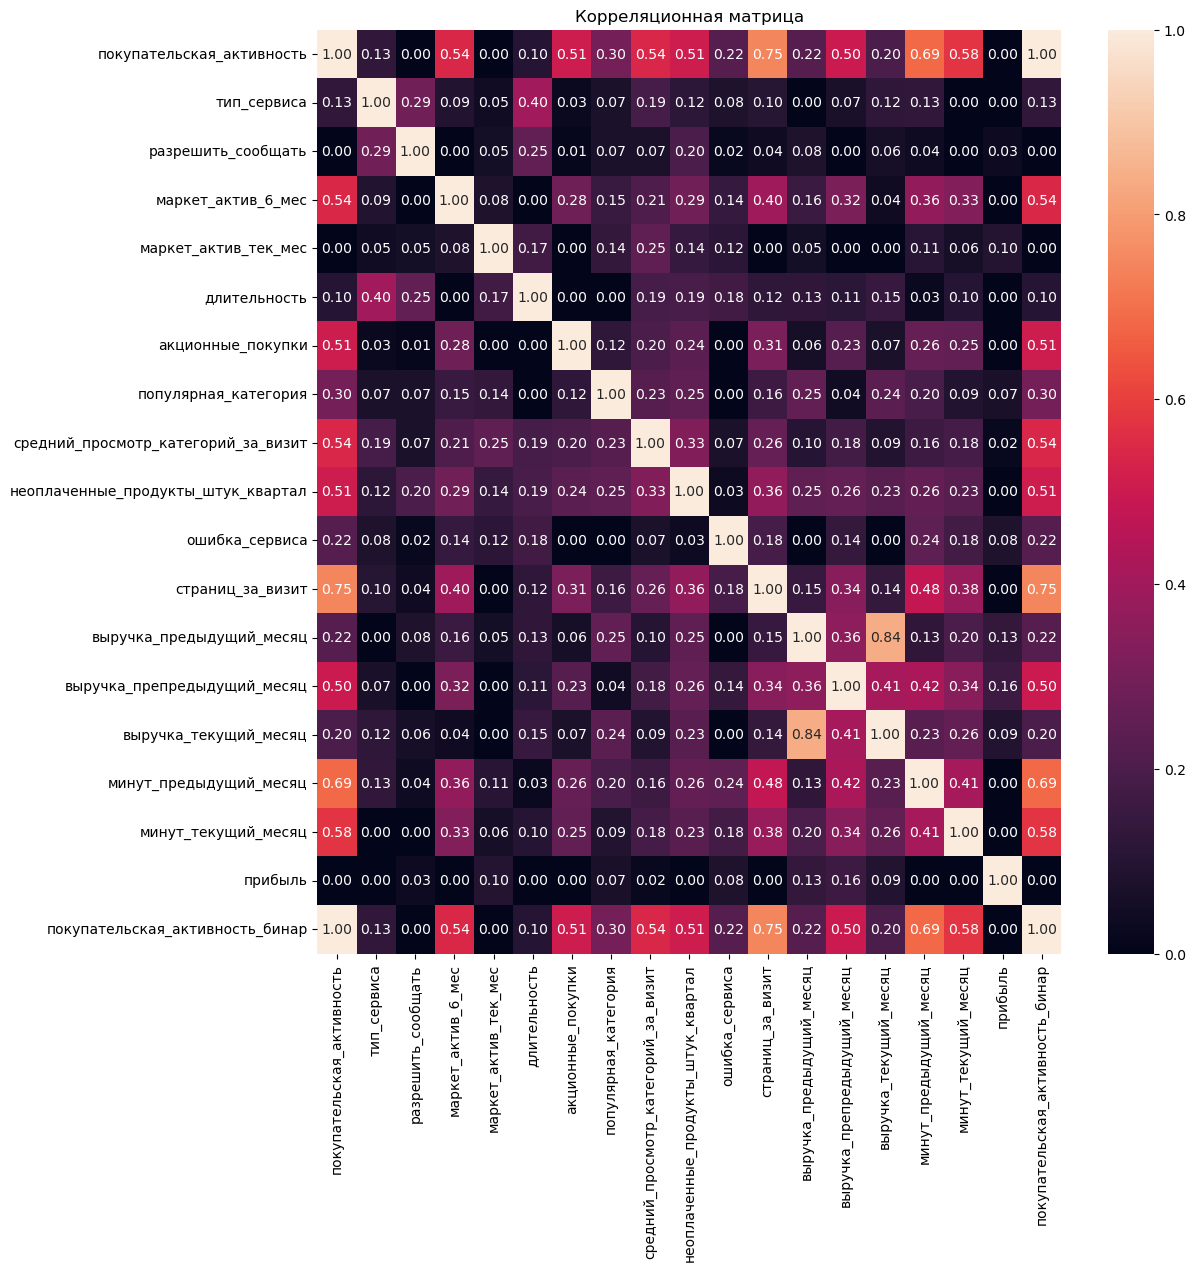

In [72]:
# рассчитаем корреляции признаков
cor_matrix = total_data.phik_matrix(interval_cols=num_col)
corr_df = pd.DataFrame(cor_matrix, index = total_data.columns, columns=total_data.columns)
ax, fig = plt.subplots(figsize=(12, 12))
ax=sns.heatmap(corr_df, annot=True, fmt='.2f')
ax.set_title('Корреляционная матрица')
plt.show()

**Вывод:** анализ корреляционной матрицы позволяет сделать вывод о том, что признаки не содержат признаков с высокой взаимной корреляцией. Отсюда можно сделать вывод о том, что мультикорреляция в признаках отсутствует. Тем не менее можно заметить, что существует высокая (по шкале Чеддока) связь между следующими признаками:
 * "страниц_за_визит" и "покупательская_активность" (0.75);
 * "выручка_предпредыдущий_месяц", "выручка_предыдущий_месяц", "выручка_текущий_месяц" - тут можно сделать заключение о стабильности потребительского поведения покупателей;
 * "акционные_покупки", "выручка_предпредыдущий_месяц" и "выручка_предыдущий_месяц".
 
Дополнительно рассмотрим взаимную зависимость между вышеперечисленными признаками.

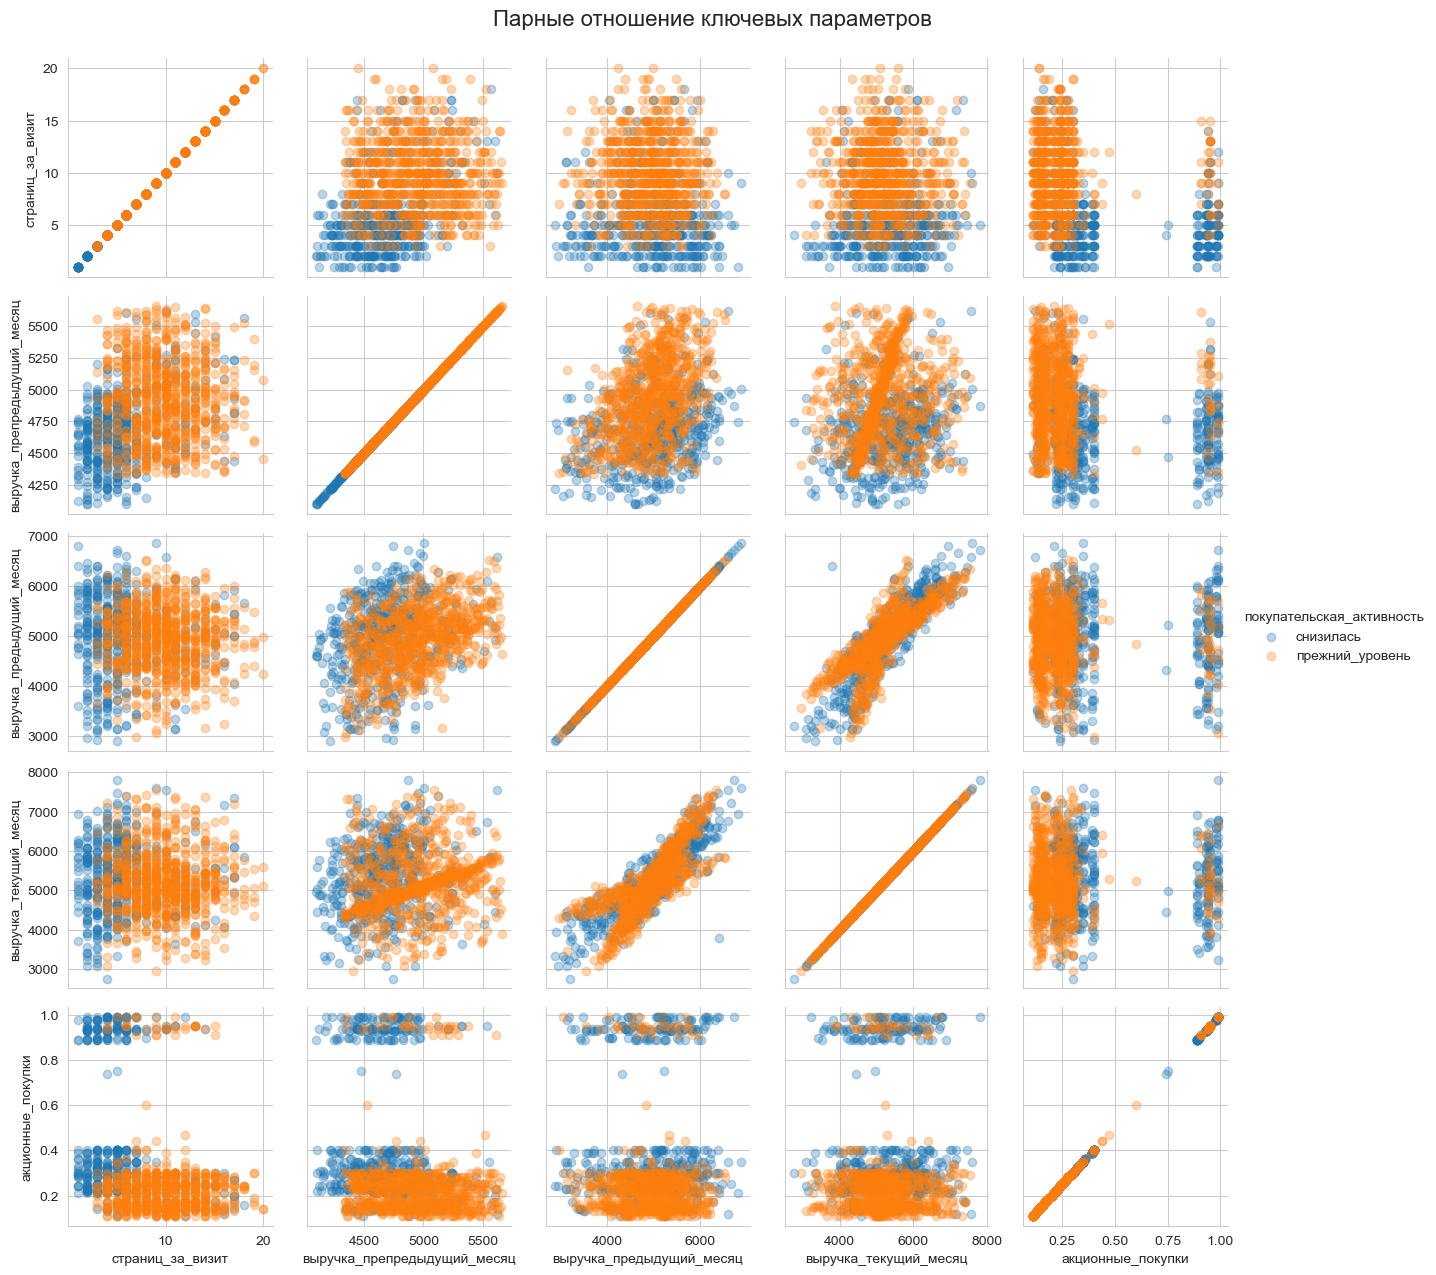

In [73]:
# 
key_cols = [
    "страниц_за_визит",
    "покупательская_активность",
    "выручка_препредыдущий_месяц",
    "выручка_предыдущий_месяц",
    "выручка_текущий_месяц",
    "акционные_покупки"    
]

sns.set_style("whitegrid")
grid = sns.PairGrid(total_data[key_cols], hue="покупательская_активность")
grid.map(plt.scatter, alpha=0.3)
grid.add_legend()
plt.suptitle('Парные отношение ключевых параметров', y=1.02, fontsize=16)
plt.show()

Анализ парных взаимосвязей между ключевыми признаками позволяет сделать следующие выводы:
 * снижение активности в основном касается покупателей с высоким уровнем акционных покупок;
 * очень высокий уровень тесноты связи между выручкой текущего и предыщего месяца;
 * низкий уровень тесноты связи между выручкой препредыщего месяца с выручкой последних двух месяцев.

## Использование пайплайнов

В рамках исследования необходимо найти модель которая будет строить прогноз покупательской активности. Для целей поиска лучшей модели будем перебирать доступные модели с вариацией их ключевых гиперпараметров.
В качестве возможных моделей будем рассматривать:
 * логистическая регрессия;
 * деревья решений;
 * KNN;
 * SVC.
 
Для целей оптимизации решения будем использовать случайный поиск при помощи инструмента 'RandomizedSearchCV'

### подготовка данных

In [74]:
RANDOM_STATE = 23
TEST_SIZE = 0.25

# разбиваем данные
X_train, X_test, y_train, y_test = train_test_split(
    total_data.drop(['покупательская_активность', 'покупательская_активность_бинар'], axis=1),
    total_data['покупательская_активность_бинар'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = total_data['покупательская_активность_бинар']
)

# создаем списки с названиями признаков
ohe_columns = ['популярная_категория', 'разрешить_сообщать', 'тип_сервиса']
num_columns = [
    'маркет_актив_6_мес',
     'маркет_актив_тек_мес',
     'длительность',
     'акционные_покупки',
     'средний_просмотр_категорий_за_визит',
     'неоплаченные_продукты_штук_квартал',
     'ошибка_сервиса',
     'страниц_за_визит',
     'выручка_предыдущий_месяц',
     'выручка_препредыдущий_месяц',
     'выручка_текущий_месяц',
     'минут_предыдущий_месяц',
     'минут_текущий_месяц'
]

### формирование пайплайна

In [75]:
# создаем пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)
num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('num', StandardScaler())
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

# создаем итоговый пайплайн 
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### подготовка перечня моделей и вариации гиперпараметров

In [76]:
# создаем список словарей моделей и гиперпараметров для перебора
param_grid = [
    # словарь для KNN
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словать для SVC
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__degree': range(1, 6),
        'models__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

### поиск лучшей модели

Поиск лучшей модели будет осуществляться при помощи случайного поиска. В качестве ключевой оценки будем использовать ROC AUC так как не зависит от порога классификации и устойчива к несбалансированным классам.

In [77]:
# поиск лучшей комбинации "модель-гиперпараметр"
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=['roc_auc', 'f1', 'accuracy'],
    refit='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
).fit(X_train, y_train)

result = pd.DataFrame(randomized_search.cv_results_)
result_sort = result[
    ['mean_fit_time', 'param_preprocessor__num', 'param_models', 'rank_test_roc_auc', 'rank_test_f1', 'rank_test_accuracy']
].sort_values('rank_test_roc_auc').reset_index(drop=True)

#print('Рейтинг моделей по показателю ROC AUC:')
display(result_sort)
print('Гиперпараметры лучшей модели:')
result_sort.loc[0, 'param_models']

c:\Users\den_m\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.90235723 0.81665615        nan 0.74004393 0.90133292 0.83136913
 0.83866847 0.78645093 0.70603324 0.89589215]
  warnings.warn(
c:\Users\den_m\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.82702146 0.73006753        nan 0.         0.83026967 0.77221439
 0.75271255 0.6883036  0.56205076 0.81628018]
  warnings.warn(
c:\Users\den_m\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.876553   0.81998414        nan 0.61728787 0.88272271 0.84571504
 0.83436955 0.79224954 0.70162834 0.87141422]
  warnings.warn(


,mean_fit_time,param_preprocessor__num,param_models,rank_test_roc_auc,rank_test_f1,rank_test_accuracy
0,0.026552,StandardScaler(),"LogisticRegression(penalty='l1', random_state=...",1,2,2
1,0.213408,StandardScaler(),"SVC(probability=True, random_state=23)",2,1,1
2,0.118068,StandardScaler(),"SVC(probability=True, random_state=23)",3,3,3
3,0.018347,StandardScaler(),DecisionTreeClassifier(random_state=23),4,5,5
4,0.025391,MinMaxScaler(),DecisionTreeClassifier(random_state=23),5,4,4
5,0.023704,MinMaxScaler(),DecisionTreeClassifier(random_state=23),6,6,6
6,0.015620,passthrough,DecisionTreeClassifier(random_state=23),7,7,7
7,0.261372,passthrough,"SVC(probability=True, random_state=23)",8,9,9
8,0.168562,MinMaxScaler(),"SVC(probability=True, random_state=23)",9,8,8
9,0.018841,passthrough,KNeighborsClassifier(),10,10,10


Гиперпараметры лучшей модели:


LogisticRegression(penalty='l1', random_state=23, solver='liblinear')

In [78]:
best_estimator = randomized_search.best_estimator_
final_model = best_estimator['models']
final_preprocessor = best_estimator['preprocessor']
X_test_transformed = final_preprocessor.transform(X_test)
y_pred = final_model.predict(X_test_transformed)

print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC-AUC score: {roc_auc_score(y_test, final_model.predict_proba(X_test_transformed)[:,1]):.2f}")

Accuracy score: 0.87
ROC-AUC score: 0.90


**Вывод:**

Лучший результат показала модель логистической регрессии с регуляризацией L1 и степенью регуляризации "С" равной 6 с масштабированием количественных данных при помощи StandardScaler. ROC-AUC модели равен 0.90, точность модели равна 0.87.

## Анализ важности признаков

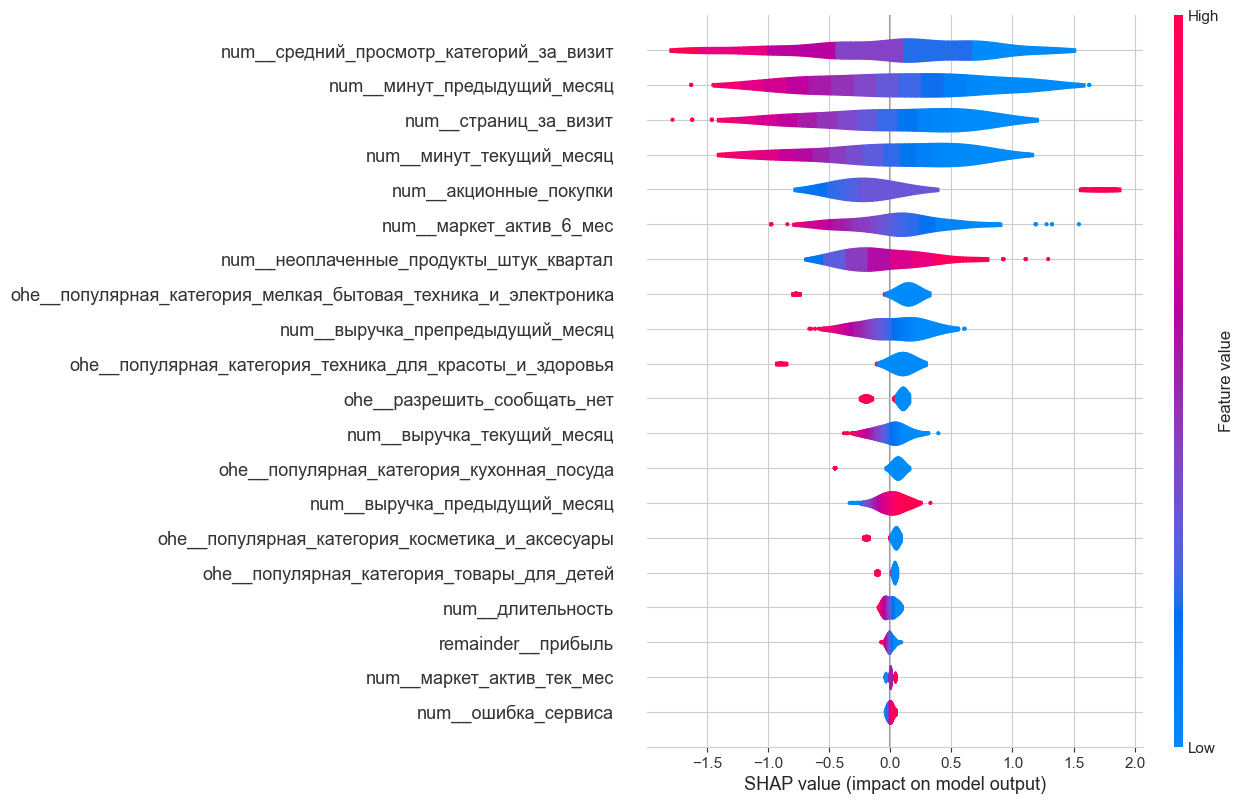

In [79]:
explainer = shap.LinearExplainer(final_model, X_test_transformed)
shap_values = explainer(X_test_transformed)
feature_names = final_preprocessor.get_feature_names_out()
shap.plots.violin(shap_values, feature_names=feature_names)

**Вывод:**

Анализ воронки shap-значений признаков модели позволяет заметить что первые 10 признаков ('средний_просмотр_категорий_за_визит' - 'маркет_актив\_6_мес') имеют достаточно высокий диапазон колебания. Начиная с 'популярная_категория_техника\_для_красоты\_и_здоровья' диапазон колебаний признаков заметно снижается что указывает на 
снижение влияния признака в итоговую оценку.

Можно говорить о том, что наибольшее влияние на покупательскую активность с точки зрения модели оказывают, в основном, признаки, связанные с интенсивностью использования сайта: 'средний_просмотр_категорий_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц', 'страниц_за_визит', 'акционные_покупки', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц'. При этом стоит отметить, что признаки: 'акционные_покупки', 'неоплаченные_продукты_штук_квартал' и 'выручка_текущий_месяц' имеют обратную зависимость.

Предпочтения в категориях товара, тип сервиса и другие оказывают несущественное влияние на покупательскую активность с точки зрения модели.

Отсюда можно сделать вывод о том, что необходимо повышать время пребывания покупателей на сайте и внедрять рекомендательные системы на сайте для удержания внимания покупателей.

## Сегментация покупателей

На основании полученной модели проведем сегментацию покупателей для тестового датасета. Для этой цели объединим данные тестового датасета с данными вероятности прогноза снижения покупательской активности и аггрегируем данные для анализа. 

Лучшая модель, полученная в рамках отбора - логистическая регрессия. Результат модели это бинарный ряд и связанный с ним непрерывный ряд вероятности. Для сегментации покупателей по уровню вероятности добавим новый признак оценки вероятности.

Ключевой интегральный показатель эффективности с точки зрения бизнеса - прибыль. Исходный датасет содержит три признака с выручкой за последние три месяца. Для удобства сегментации добавим новый признак - общая выручка.

In [80]:
# создадим сводный датасет
full_data = X_test.copy()
full_data['prob_decrease'] = final_model.predict_proba(X_test_transformed)[:,1]
full_data['покупательская_активность_predict'] = y_pred
full_data = full_data.sort_values(by='prob_decrease', ascending=False)

# созданим функция перевода вероятности в категорийный ряд
def prob_group(x):
    if x <= 0.25:
        return 'низкая'
    elif x > 0.25 and x <= 0.5:
        return 'ниже среднего'
    elif x > 0.5 and x <= 0.75:
        return 'умеренная'
    elif x > 0.75 and x <= 1.0:
        return 'высокая'

# добавим новые признаки оценки вероятности
full_data['proba_group'] = full_data['prob_decrease'].apply(lambda x: prob_group(x))
full_data['общая_выручка'] = full_data[[
    'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц', 
    'выручка_текущий_месяц'
]].sum(axis=1)
full_data['рентабельность'] = full_data['прибыль'] / full_data['общая_выручка']

# выведем количество наблюдений в датасете
print(f"Количество покупателей: {full_data.shape[0]}")

Количество покупателей: 324


Тестовый датасет содержит 324 покупателей. В рамках анализа важности признаков мы выделили ключевые признаки которые оказывают существенное влияние на прогноз модели:
 * 'средний_просмотр_категорий_за_визит	'
 * 'минут_предыдущий_месяц'
 * 'минут_текущий_месяц'
 * 'страниц_за_визит'
 * 'акционные_покупки'
 * 'выручка_препредыдущий_месяц'
 * 'выручка_предыдущий_месяц'
 * 'выручка_текущий_месяц'
 * 'маркет_актив_6\_мес'
 * 'прибыль'
 
 Для целей анализа рассмотрим распределение ключевых признаков в зависимости от вероятности снижения покупательской активности.

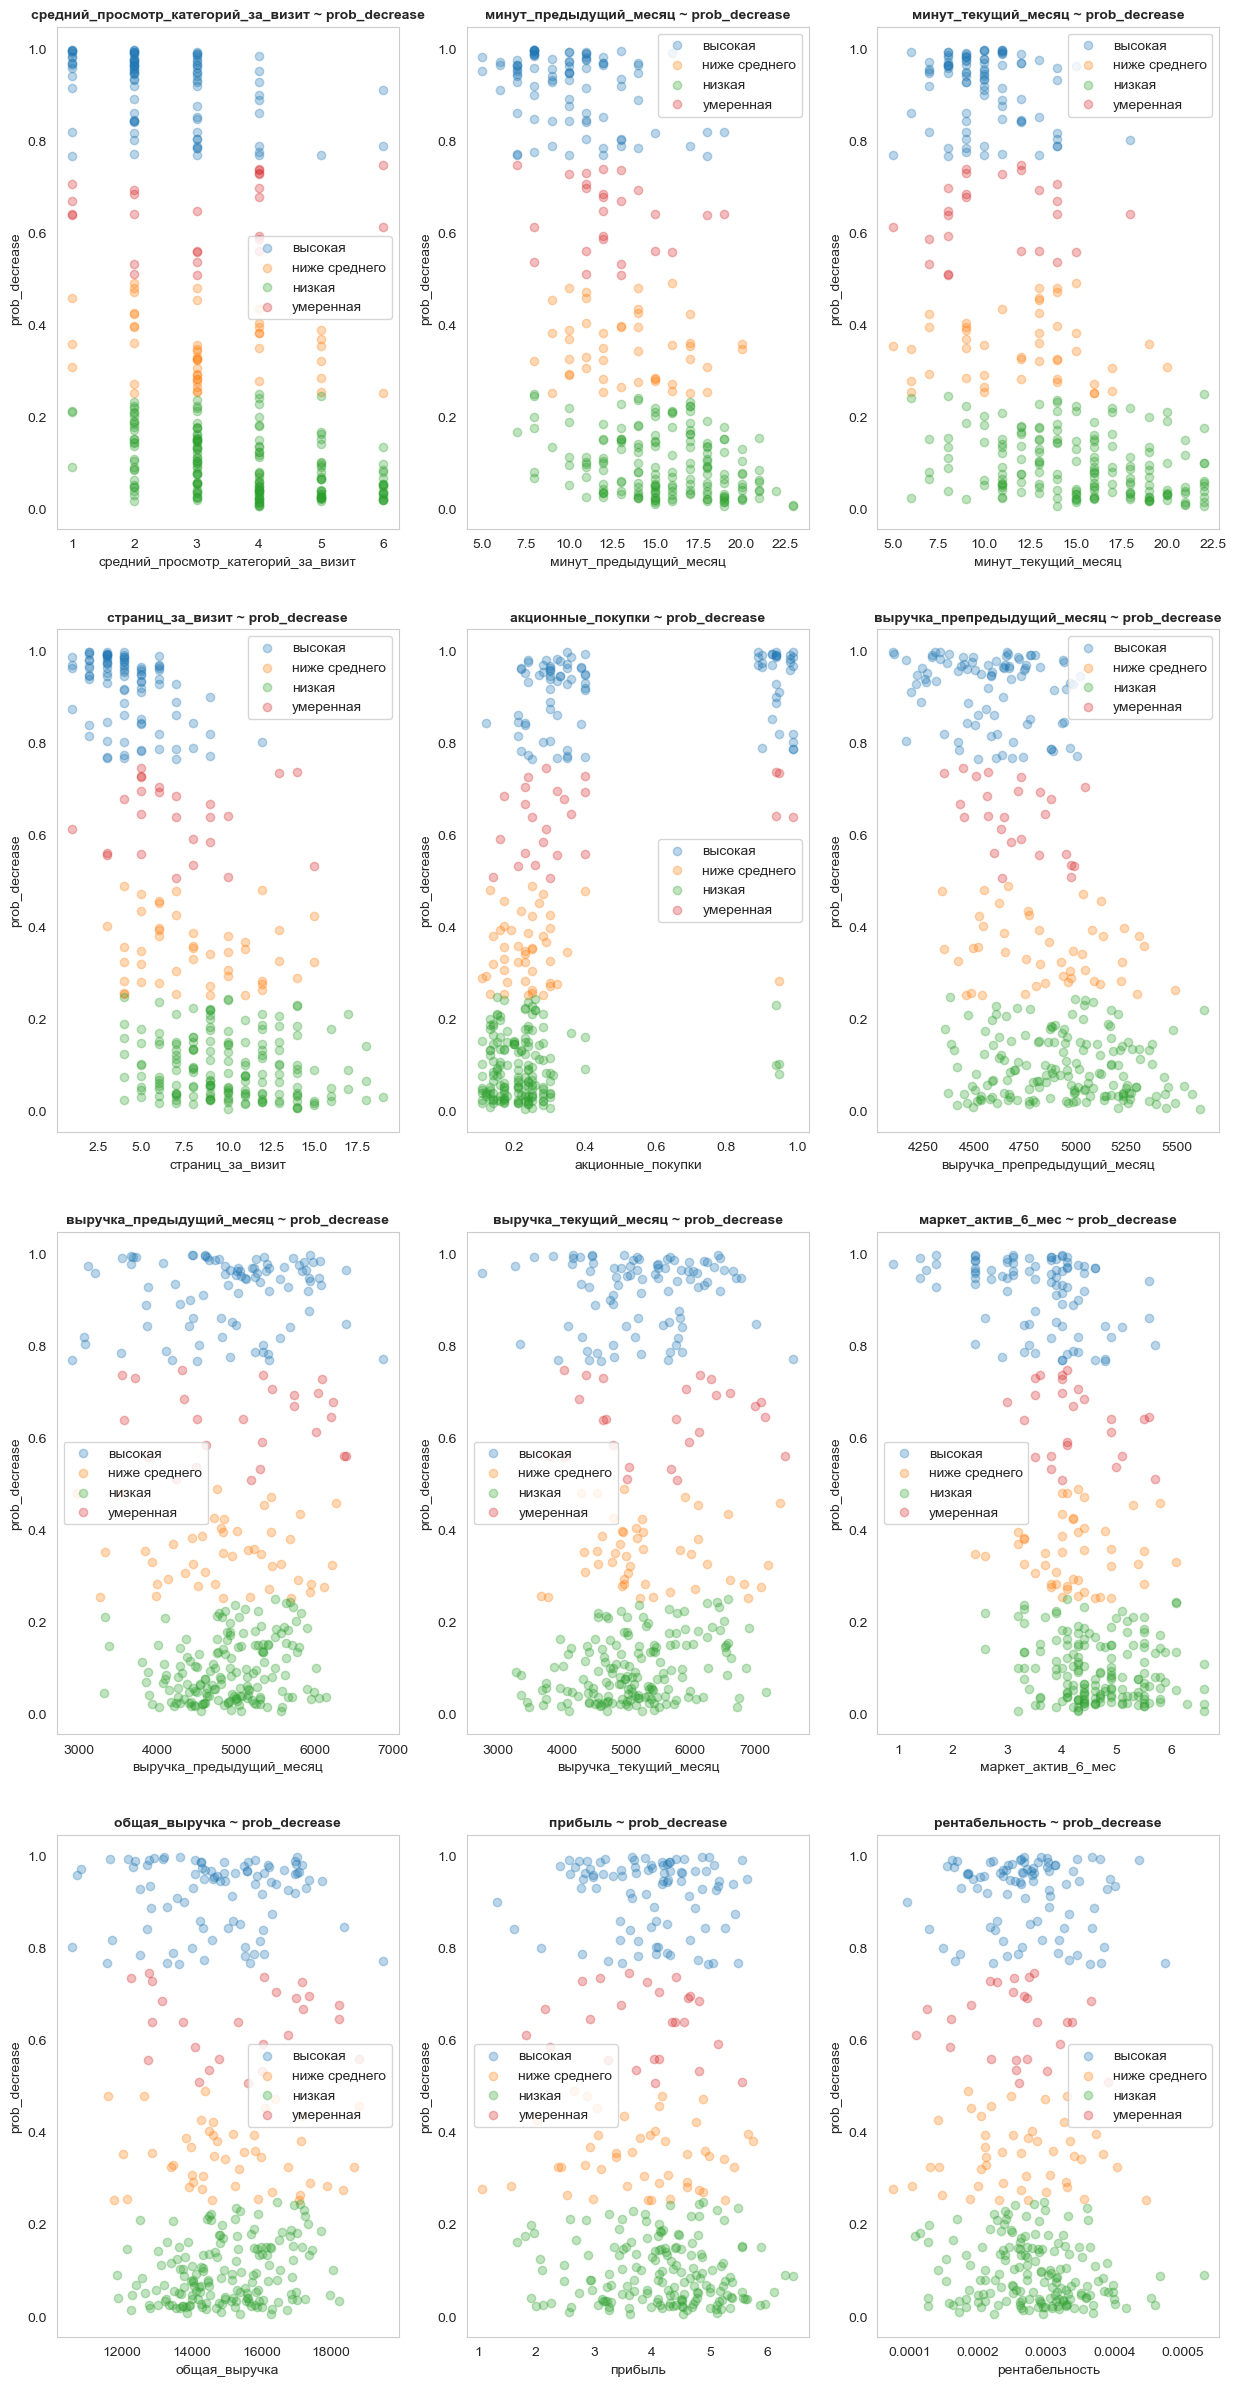

In [86]:
# данные для графика
col_y = 'prob_decrease'
key_parameters =  [
     'средний_просмотр_категорий_за_визит',
     'минут_предыдущий_месяц',
     'минут_текущий_месяц',
     'страниц_за_визит',
     'акционные_покупки',
     'выручка_препредыдущий_месяц',
     'выручка_предыдущий_месяц',
     'выручка_текущий_месяц',
     'маркет_актив_6_мес',
     'общая_выручка',
     'прибыль',
     'рентабельность',
]

color_group = full_data['proba_group']
i=-1 # счетчик перебора key_parameters    

# отрисовка графиков
fig, ax = plt.subplots(4, 3, figsize=(15, 30))
for row in range(4):
    for col in range(3):
        i += 1
        parameter = key_parameters[i]
        for cat_i in set(color_group):
            mask = color_group == cat_i
            x = full_data[parameter]
            y = full_data[col_y]
            ax[row, col].scatter(x[mask], y[mask], label=cat_i, alpha=0.3)
        ax[row, col].set_xlabel(parameter)
        ax[row, col].set_ylabel('prob_decrease')
        ax[row, col].set_title(f"{parameter} ~ {col_y}", fontsize=10, fontweight="bold")
        ax[row, col].grid()
        ax[row, col].legend()
plt.show()

Построим таблицы распределения выручки и прибыли по категориям и уровню снижения риска.

In [84]:
# построим таблицу распределение прибыли по категориям и уровню риска снижения
pivot_table = full_data.pivot_table(index="популярная_категория", columns='proba_group', values='общая_выручка', aggfunc='sum')
pivot_table.columns.tolist()
columns_ordered = ['низкая', 'ниже среднего', 'умеренная', 'высокая']
print("Таблица: распределение выручки по продуктовым категориям и уровню риска")
pivot_table.reindex(columns=columns_ordered).sort_values(by='высокая', ascending=False)

Таблица: распределение выручки по продуктовым категориям и уровню риска


proba_group,низкая,ниже среднего,умеренная,высокая
популярная_категория,,,,
косметика_и_аксесуары,435647.9,80989.2,90914.2,363206.7
товары_для_детей,397505.9,200983.6,99303.0,339010.7
кухонная_посуда,197902.4,83352.1,105446.1,218130.2
домашний_текстиль,569756.7,136713.7,17150.5,213884.8
техника_для_красоты_и_здоровья,393539.7,85759.3,40385.4,118701.1
мелкая_бытовая_техника_и_электроника,493270.3,91660.1,30936.5,46928.5


In [83]:
# построим таблицу распределение прибыли по категориям и уровню риска снижения
pivot_table = full_data.pivot_table(index='популярная_категория', columns='proba_group', values='прибыль', aggfunc='sum')
pivot_table.columns.tolist()
columns_ordered = ['низкая', 'ниже среднего', 'умеренная', 'высокая']
print("Таблица: распределение прибыли по продуктовым категориям и уровню риска")
pivot_table.reindex(columns=columns_ordered).sort_values(by='высокая', ascending=False)

Таблица: распределение прибыли по продуктовым категориям и уровню риска


proba_group,низкая,ниже среднего,умеренная,высокая
популярная_категория,,,,
товары_для_детей,111.23,55.34,23.97,98.50
косметика_и_аксесуары,128.13,19.29,28.50,90.72
кухонная_посуда,56.59,20.47,21.73,55.11
домашний_текстиль,154.85,37.52,3.91,54.61
техника_для_красоты_и_здоровья,107.46,16.60,10.08,36.78
мелкая_бытовая_техника_и_электроника,135.38,23.15,8.46,12.44


**Вывод:**

Анализ распределения показателей позволяет выделить следующие наблюдения для покупателей с высокой вероятностью снижения активности:
 * низкий средний просмотром категорий за визит;
 * низкое временя проведенным на сайте;
 * небольшое количество просмотренных страниц за визит;
 * сосредоточены на акционных предложениях;
 * выручка и активность практически не зависимы;
 * заметна кластеризация выручки и прибыли в покупателям с низкой и высокой вероятностью снижения активности;
 * ключевые товарные категории это "товары для детей" и "косметика и аксесуары".
 
 Таким образом, можно сделать средний портрет покупателя который имеет высокий риск снижения покупательской активности: целевой визит сайта магазина с целью конкретной покупки, скорее всего связанной с акционным предложением. Так как ранее в рамках анализа важности признаков мы выявили, что категории не оказывают существенного влияния на потребительскую активность - сегментация в зависимости от товарных категорий не имеет смысла.
 
 Отсюда можно сделать вывод о том, что работа с потребителями с высокой вероятностью снижения потребительской активности должна быть направлена на повышение внимания данных потребителей по работе с сайтом, разработка и интенсификация акционных предложений в основном в товарной группе "товары для детей" и "косметика и аксесуары".

## Общий вывод

В рамках исследования была проведена работа по анализу и предобработке данных Заказчика. Данные были представлены четырьмя датасетами. Данные были успешно загружены и проанализированы. Можно отметить высокое качество данных, они не содержали явных дубликатов. В рамках предобработки данных были скорректированы названия столбцов, были выявлены небольшие ошибки, которые были устранены.

В рамках исследовательского анализа данных исключено одно наблюдение которое было признано аномалией по показателю "выручка_текущего_месяца". Стоит отметить, что большинство покупателей (61.7%) сохраняют свою активность на прежнем уровне. Значительная часть покупателей используют тип сервиса "стандарт" (71.1%). 74% покупателей разрешают отправку сообщение и предложений. Наиболее популярные категории товаров это "товары для детей" и "домашний текстиль".

В рамках корреляционного анализа было выявлено, что мультикорреляция в признаках отсутствует. Тем не менее можно заметить, что существует высокая (по шкале Чеддока) связь между следующими признаками:
 * "страниц_за_визит" и "покупательская_активность" (0.75);
 * "выручка_предпредыдущий_месяц", "выручка_предыдущий_месяц", "выручка_текущий_месяц" - тут можно сделать заключение о стабильности потребительского поведения покупателей;
 * "акционные_покупки", "выручка_предпредыдущий_месяц" и "выручка_предыдущий_месяц".

В рамках отбора модели были проанализированы следующие модели: деревья решений, метод опорных векторов, логистическая регрессия, а также KNN с различными комбинациями ключевых гиперпараметров. Лучший результат показала модель логистической регрессии с регуляризацией L1 и степенью регуляризации "С" равной 6.

Анализ важности признаков выявил следующие ключевые признаки:
   * 'средний_просмотр_категорий_за_визит'
   * 'минут_предыдущий_месяц'
   * 'минут_текущий_месяц'
   * 'страниц_за_визит'
   * 'акционные_покупки'
   * 'выручка_препредыдущий_месяц'
   * 'выручка_текущий_месяц'. 
При этом стоит отметить, что признаки: 'акционные_покупки', 'неоплаченные_продукты_штук_квартал' и 'выручка_текущий_месяц' имеют обратную линейную зависимость. Предпочтения в категориях товара, тип сервиса и другие оказывают несущественное влияние на покупательскую активность.

Портрет типичного покупателя который имеет высокий риск снижения покупательской активности: целевой визит сайта магазина с целью конкретной покупки, скорее всего связанной с акционным предложением. 
 
Работа с потребителями с высокой вероятностью снижения потребительской активности должна быть направлена на повышение внимания данных потребителей по работе с сайтом, разработка и интенсификация акционных предложений и предложение смежных товарных групп.
